# Experiment 3: Semantic Fidelity Comparison

__Objective:__ Compute the correlation between human judgement and traditional metrics (e.g. BLEU and METEOR,etc.) compare it to the correlation between human judgement and embedding-based metrics (e.g., BERTScore, CLIPScore, etc.). Optional: If time permits, compute correlation between human judgement and the visual attention map alignment, then compare against traditional and embedding-based metrics.

__Research Question(s):__ Can embedding-based metrics or visual attention maps help quantify caption fidelity beyond BLEU and METEOR scores?

## Setup and Imports

In [1]:
import logging
# Configure logging
logging.basicConfig(
    level=logging.INFO, # Set the minimum logging level (e.g., INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y:%m:%d %H:%M"
)
# Get a logger instance for this notebook
logger = logging.getLogger(__name__) 

logger.info("Notebook execution started.")

2025:07:30 15:53 - INFO - Notebook execution started.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation_sheet_reader import (
    read_human_evaluation_sheets, 
    read_evaluation_sheet_and_compute_metrics
)
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from vtt.evaluation.metrics import (
    compute_meteor_scores,
    compute_bertscore,
)
from tqdm.notebook import tqdm

## Load Human Evaluation Data

In [4]:
# Define the Directory Containing Evaluation Spreadsheets
evaluation_data_directory = './human_evaluation_sheets'

# Check if the directory exists
if not os.path.exists(evaluation_data_directory):
    logger.warning(f"The specified evaluation data directory does not exist: {evaluation_data_directory}")
    logger.warning("Please create the directory and place your evaluation Excel files inside, or update the path.")

# Load the Data into a DataFrame
logger.info(f"Loading evaluation data from: {os.path.abspath(evaluation_data_directory)}")
evaluation_df = read_human_evaluation_sheets(evaluation_data_directory)

2025:07:30 15:53 - INFO - Loading evaluation data from: /mnt/c/grad_school/northeastern/ie7374/GenAI_Project/experiments/experiment3/human_evaluation_sheets
2025:07:30 15:53 - INFO - Scanning directory: ./human_evaluation_sheets for Excel files...
2025:07:30 15:53 - INFO - Successfully read: human_evaluation_sheet--arundhati.xlsx
2025:07:30 15:53 - INFO - Successfully read: human_evaluation_sheet--curtis.xlsx
2025:07:30 15:53 - INFO - Successfully read: human_evaluation_sheet--desiree.xlsx
2025:07:30 15:53 - INFO - Successfully read: human_evaluation_sheet--divya.xlsx
2025:07:30 15:53 - INFO - Successfully read: human_evaluation_sheet--minal.xlsx


In [5]:
evaluation_df.info()
pd.concat([evaluation_df.head(), evaluation_df.tail()], axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Image Filename             250 non-null    object 
 1   Generated Caption (Model)  250 non-null    object 
 2   Adequacy (1-5)             247 non-null    float64
 3   Fluency (1-5)              247 non-null    float64
 4   Overall Quality (1-5)      247 non-null    float64
 5   Comments                   105 non-null    object 
 6   Generation Method          250 non-null    object 
 7   Ground Truth Caption       250 non-null    object 
 8   source_file                250 non-null    object 
dtypes: float64(3), object(6)
memory usage: 17.7+ KB


,Image Filename,Generated Caption (Model),Adequacy (1-5),Fluency (1-5),Overall Quality (1-5),Comments,Generation Method,Ground Truth Caption,source_file
0,862054277_34b5a6f401.jpg,a man in a wetsuit is riding a dirt bike,1.0,5.0,1.0,NaN,Greedy,a young girl in a pink swimsuit,human_evaluation_sheet--arundhati.xlsx
1,3181701312_70a379ab6e.jpg,a man in a blue shirt is standing in front of ...,2.0,5.0,1.0,NaN,Beam Search,a man covered with a blanket is asleep on the ...,human_evaluation_sheet--arundhati.xlsx
2,624742559_ff467d8ebc.jpg,a woman is sitting on a bench reading a newspaper,1.0,5.0,1.0,NaN,Beam Search,a little boy is climbing on the monkey bars at...,human_evaluation_sheet--arundhati.xlsx
3,1119463452_69d4eecd08.jpg,a little girl in a pink shirt is swinging on a...,2.0,5.0,2.0,NaN,Greedy,smiling little girl swimming in outdoor pool,human_evaluation_sheet--arundhati.xlsx
4,1332722096_1e3de8ae70.jpg,a woman in a blue shirt is walking with a dog,1.0,5.0,1.0,NaN,Greedy,two girls and a woman walking on the sidewalk,human_evaluation_sheet--arundhati.xlsx
245,2429729667_42effc165d.jpg,a little girl in a pink shirt is swinging on a...,1.0,2.0,2.0,Kids are throwing tomatoes.,Beam Search,a young boy and girl are trying to hit a man w...,human_evaluation_sheet--minal.xlsx
246,2899374885_f3b2b1a290.jpg,a young girl in a pink shirt is standing in fr...,2.0,3.0,3.0,A baby is drinking water from the fountain.,Greedy,a baby sticking out his tonge while looking at...,human_evaluation_sheet--minal.xlsx
247,753285176_f21a2b984d.jpg,a girl in a pink bathing suit jumps into the w...,2.0,3.0,3.0,Two people are running on the grass.,Beam Search,a woman and child walking uphill,human_evaluation_sheet--minal.xlsx
248,2777021428_0b2ac3e987.jpg,a little girl in a pink dress is playing with ...,1.0,3.0,3.0,A little boy in a hate is swinging on the swin...,Beam Search,a little boy in blue and wearing a backwards c...,human_evaluation_sheet--minal.xlsx
249,3050976633_9c25cf6fa0.jpg,two young boys playing soccer,NaN,NaN,NaN,NaN,Beam Search,these people are playing a soccer type game,human_evaluation_sheet--minal.xlsx


## Compute Automatic Metrics

In [6]:
eval_file = "./human_evaluation_sheet.xlsx"
df_with_metrics = read_evaluation_sheet_and_compute_metrics(eval_file)

2025:07:30 15:53 - INFO - Reading evaluation sheet: ./human_evaluation_sheet.xlsx
2025:07:30 15:53 - INFO - Calculating per-pair BLEU and METEOR scores...
100%|██████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.62it/s]
2025:07:30 15:53 - INFO - Calculating per-pair BERTScore (this may take a while)...
/home/curtis/anaconda3/envs/northeastern/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
df_with_metrics.info()
df_with_metrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Image Filename             100 non-null    object 
 1   Generated Caption (Model)  100 non-null    object 
 2   Generation Method          100 non-null    object 
 3   Ground Truth Caption       100 non-null    object 
 4   BLEU-1                     100 non-null    float64
 5   BLEU-2                     100 non-null    float64
 6   BLEU-3                     100 non-null    float64
 7   BLEU-4                     100 non-null    float64
 8   METEOR                     100 non-null    float64
 9   BERTScore_P                100 non-null    float64
 10  BERTScore_R                100 non-null    float64
 11  BERTScore_F1               100 non-null    float64
dtypes: float64(8), object(4)
memory usage: 9.5+ KB


,Image Filename,Generated Caption (Model),Generation Method,Ground Truth Caption,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,BERTScore_P,BERTScore_R,BERTScore_F1
0,862054277_34b5a6f401.jpg,a man in a wetsuit is riding a dirt bike,Greedy,a young girl in a pink swimsuit,0.300000,0.182574,0.076653,0.049394,0.205479,0.900994,0.915368,0.908124
1,3181701312_70a379ab6e.jpg,a man in a blue shirt is standing in front of ...,Beam Search,a man covered with a blanket is asleep on the ...,0.307692,0.160128,0.063283,0.039074,0.178571,0.918208,0.918805,0.918506
2,624742559_ff467d8ebc.jpg,a woman is sitting on a bench reading a newspaper,Beam Search,a little boy is climbing on the monkey bars at...,0.327492,0.054582,0.032278,0.024437,0.169492,0.916734,0.915468,0.916100
3,1119463452_69d4eecd08.jpg,a little girl in a pink shirt is swinging on a...,Greedy,smiling little girl swimming in outdoor pool,0.250000,0.150756,0.062757,0.039864,0.340741,0.890760,0.901141,0.895920
4,1332722096_1e3de8ae70.jpg,a woman in a blue shirt is walking with a dog,Greedy,two girls and a woman walking on the sidewalk,0.272727,0.165145,0.069007,0.044116,0.163043,0.897347,0.933030,0.914841


## Generate Correlation Matrix

In [8]:
# Merge the two DataFrames
merged_df = pd.merge(
    evaluation_df,
    df_with_metrics,
    on=['Image Filename', 'Generated Caption (Model)'],
    how='inner',
    # Suffixes help differentiate columns with the same name (e.g., 'Generation Method')
    # from the two original dataframes.
    suffixes=('_human', '_auto')
)

merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Image Filename              250 non-null    object 
 1   Generated Caption (Model)   250 non-null    object 
 2   Adequacy (1-5)              247 non-null    float64
 3   Fluency (1-5)               247 non-null    float64
 4   Overall Quality (1-5)       247 non-null    float64
 5   Comments                    105 non-null    object 
 6   Generation Method_human     250 non-null    object 
 7   Ground Truth Caption_human  250 non-null    object 
 8   source_file                 250 non-null    object 
 9   Generation Method_auto      250 non-null    object 
 10  Ground Truth Caption_auto   250 non-null    object 
 11  BLEU-1                      250 non-null    float64
 12  BLEU-2                      250 non-null    float64
 13  BLEU-3                      250 non

,Image Filename,Generated Caption (Model),Adequacy (1-5),Fluency (1-5),Overall Quality (1-5),Comments,Generation Method_human,Ground Truth Caption_human,source_file,Generation Method_auto,Ground Truth Caption_auto,BLEU-1,BLEU-2,BLEU-3,BLEU-4,METEOR,BERTScore_P,BERTScore_R,BERTScore_F1
0,862054277_34b5a6f401.jpg,a man in a wetsuit is riding a dirt bike,1.0,5.0,1.0,NaN,Greedy,a young girl in a pink swimsuit,human_evaluation_sheet--arundhati.xlsx,Greedy,a young girl in a pink swimsuit,0.300000,0.182574,0.076653,0.049394,0.205479,0.900994,0.915368,0.908124
1,3181701312_70a379ab6e.jpg,a man in a blue shirt is standing in front of ...,2.0,5.0,1.0,NaN,Beam Search,a man covered with a blanket is asleep on the ...,human_evaluation_sheet--arundhati.xlsx,Beam Search,a man covered with a blanket is asleep on the ...,0.307692,0.160128,0.063283,0.039074,0.178571,0.918208,0.918805,0.918506
2,624742559_ff467d8ebc.jpg,a woman is sitting on a bench reading a newspaper,1.0,5.0,1.0,NaN,Beam Search,a little boy is climbing on the monkey bars at...,human_evaluation_sheet--arundhati.xlsx,Beam Search,a little boy is climbing on the monkey bars at...,0.327492,0.054582,0.032278,0.024437,0.169492,0.916734,0.915468,0.916100
3,1119463452_69d4eecd08.jpg,a little girl in a pink shirt is swinging on a...,2.0,5.0,2.0,NaN,Greedy,smiling little girl swimming in outdoor pool,human_evaluation_sheet--arundhati.xlsx,Greedy,smiling little girl swimming in outdoor pool,0.250000,0.150756,0.062757,0.039864,0.340741,0.890760,0.901141,0.895920
4,1332722096_1e3de8ae70.jpg,a woman in a blue shirt is walking with a dog,1.0,5.0,1.0,NaN,Greedy,two girls and a woman walking on the sidewalk,human_evaluation_sheet--arundhati.xlsx,Greedy,two girls and a woman walking on the sidewalk,0.272727,0.165145,0.069007,0.044116,0.163043,0.897347,0.933030,0.914841


2025:07:30 15:54 - INFO - 
Unique Generation Methods found: ['Greedy' 'Beam Search']
2025:07:30 15:54 - INFO - 
--- Processing Correlation for Generation Method: Greedy ---
2025:07:30 15:54 - INFO - 
Correlation Matrix for Greedy (Spearman, Pairwise Deletion):

2025:07:30 15:54 - INFO - Correlation heatmap for Greedy saved to correlation_matrix_heatmap_greedy.png


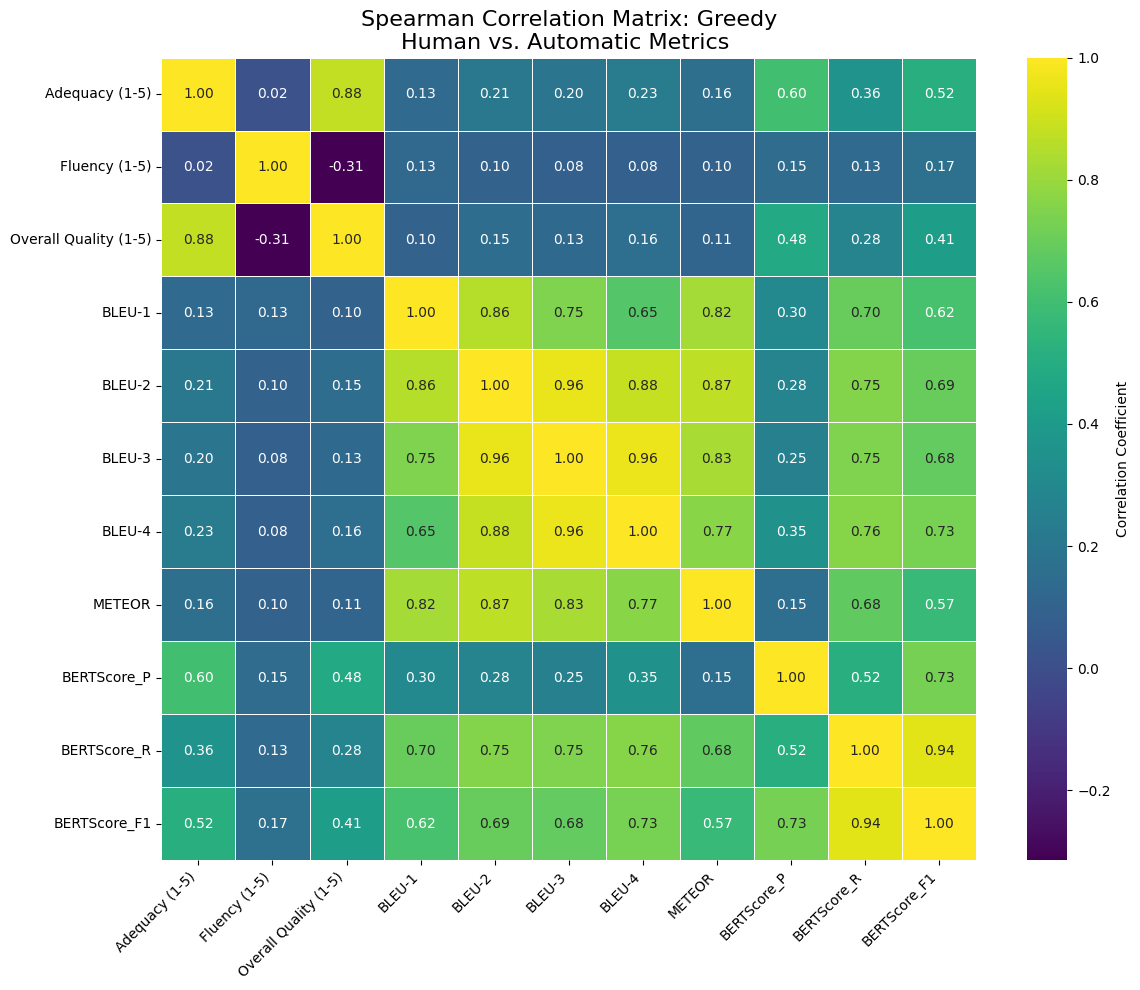

2025:07:30 15:54 - INFO - 
--- Processing Correlation for Generation Method: Beam Search ---
2025:07:30 15:54 - INFO - 
Correlation Matrix for Beam Search (Spearman, Pairwise Deletion):

2025:07:30 15:54 - INFO - Correlation heatmap for Beam Search saved to correlation_matrix_heatmap_beam_search.png


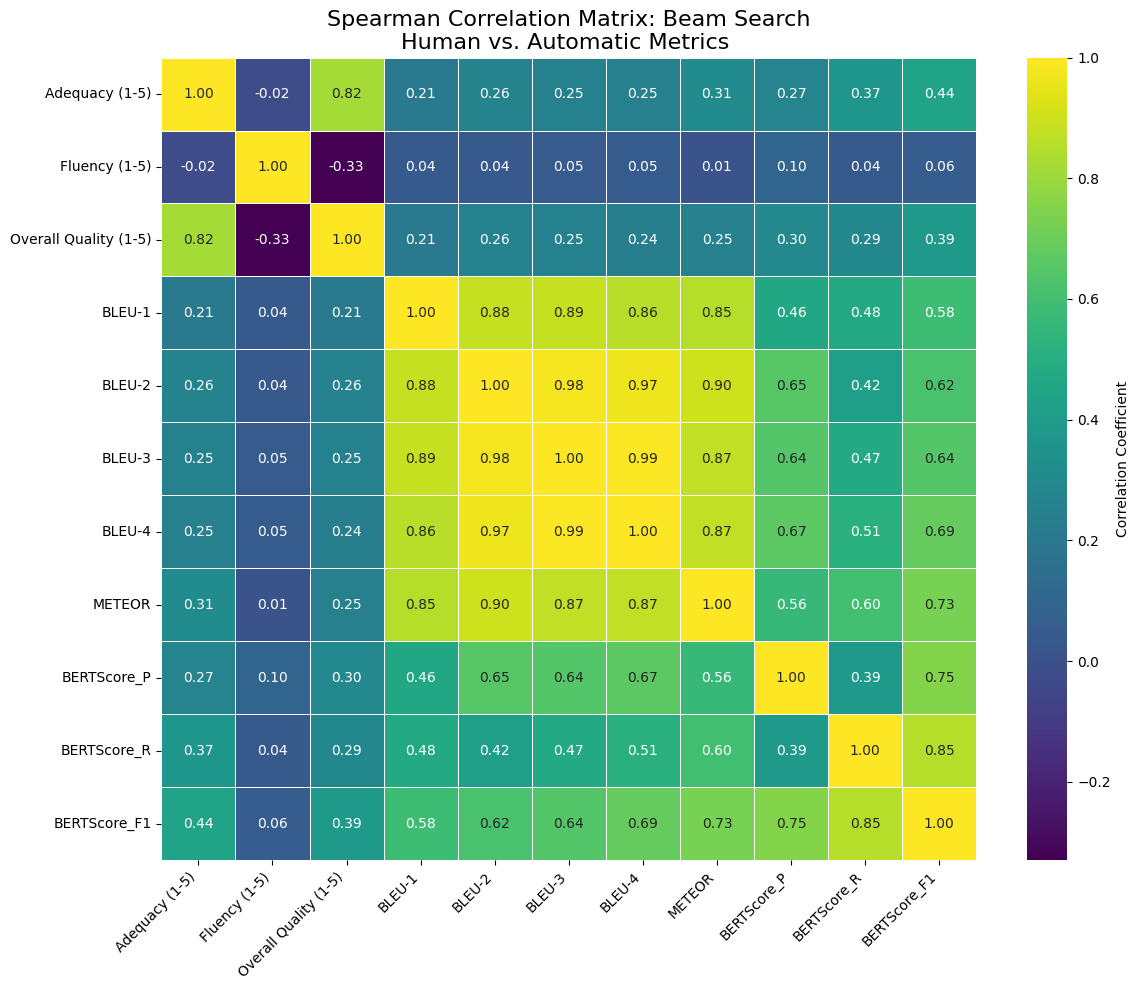

In [9]:
# Specify the correlation method
corr_method = "spearman"

# Define the human and automatic metric columns
human_metrics = [
    'Adequacy (1-5)',
    'Fluency (1-5)',
    'Overall Quality (1-5)'
]
automatic_metrics = [
    'BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4',
    'METEOR',
    'BERTScore_P', 'BERTScore_R', 'BERTScore_F1'
]

# Get unique generation methods
# The 'Generation Method' column might have suffixes due to merge, ensure we pick the correct one.
# Assuming 'Generation Method_human' is the one to use for filtering if both exist.
if 'Generation Method_human' in merged_df.columns:
    generation_method_col = 'Generation Method_human'
elif 'Generation Method' in merged_df.columns:
    generation_method_col = 'Generation Method'
else:
    logger.error("Could not find 'Generation Method' column in the merged DataFrame.")
    generation_method_col = None # Set to None to prevent further errors

if generation_method_col:
    unique_generation_methods = merged_df[generation_method_col].unique()
    logger.info(f"\nUnique Generation Methods found: {unique_generation_methods}")

    # Loop through each generation method to compute separate correlation matrices
    for method in unique_generation_methods:
        logger.info(f"\n--- Processing Correlation for Generation Method: {method} ---")

        # Filter the merged DataFrame for the current generation method
        method_df = merged_df[merged_df[generation_method_col] == method].copy()

        # Check if there's enough data for correlation
        if method_df.empty:
            logger.warning(f"No data available for generation method: {method}. Skipping correlation.")
            continue

        # Select only the metric columns for correlation
        correlation_data_for_method = method_df[human_metrics + automatic_metrics]

        # Compute the correlation matrix for the current method
        if len(correlation_data_for_method.columns) > 1: # Ensure at least two columns to correlate
            correlation_matrix = correlation_data_for_method.corr(method=corr_method)

            logger.info(f"\nCorrelation Matrix for {method} ({corr_method.title()}, Pairwise Deletion):\n")

            # Visualize the correlation matrix as a heatmap for the current method
            # plt.figure(figsize=(12, 10))
            fig, ax = plt.subplots(figsize=(12, 10))
            sns.heatmap(
                correlation_matrix,
                annot=True,
                cmap='viridis',
                fmt=".2f",
                linewidths=.5,
                cbar_kws={'label': 'Correlation Coefficient'},
                # vmin=-1,
                # vmax=1,
                ax=ax
            )
            ax.set_title(f'{corr_method.title()} Correlation Matrix: {method}\nHuman vs. Automatic Metrics ', fontsize=16)
            plt.xticks(rotation=45, ha='right', fontsize=10)
            plt.yticks(rotation=0, fontsize=10)
            plt.tight_layout()

            # Save the plot
            plot_filename = f'correlation_matrix_heatmap_{method.replace(" ", "_").lower()}.png'
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            logger.info(f"Correlation heatmap for {method} saved to {plot_filename}")
            plt.show()
        else:
            logger.warning(f"Insufficient columns to compute correlation matrix for method: {method}. Need at least two numeric columns.")

else:
    logger.error("Correlation matrices could not be computed as 'Generation Method' column was not found.")


## Interpretation

### Greedy

__Human Judgment Consistency:__
The human evaluation metrics (Adequacy (1-5), Fluency (1-5), Overall Quality (1-5)) are very strongly and positively correlated with each other (0.80 - 0.90). This indicates high internal consistency in human perception of quality; captions ranked high on adequacy are also highly ranked for fluency and overall quality. This is a good sign for the reliability of your human annotations.

__Automatic Metric Inter-correlations:__
- Traditional Metrics: BLEU scores (BLEU-1 to BLEU-4) are extremely highly correlated with each other (>0.90), as expected for variations of the same n-gram overlap principle. METEOR shows moderate-to-strong correlation with BLEU scores (0.60-0.70).
- Embedding-Based Metrics: BERTScore components (BERTScore_P, BERTScore_R, BERTScore_F1) are also very highly correlated with each other (>0.90). This indicates they capture semantic similarity consistently across precision, recall, and F1.
- Cross-Automatic (Traditional vs. Embedding): BERTScore metrics show moderate positive correlation with BLEU (0.30-0.40) and METEOR (0.20-0.30). This suggests that while they are related, embedding-based metrics capture different aspects of text similarity compared to traditional n-gram based methods.

__Alignment with Human Judgment (Addressing Research Question):__
- Traditional Metrics (BLEU, METEOR) vs. Human Judgment: The correlations between human metrics (Adequacy, Fluency, Overall Quality) and BLEU/METEOR scores are consistently weak to negligible (0.20 - 0.28 range). This implies that these traditional metrics are not very good at monotonically predicting how humans would rank the quality of captions generated by the Greedy method.
- Embedding-Based Metrics (BERTScore) vs. Human Judgment: In contrast, BERTScore metrics show moderate positive correlations with human judgments. Specifically, BERTScore_F1 has the strongest correlation (0.45-0.46) with Adequacy, Fluency, and Overall Quality. This indicates a much better alignment: as BERTScore ranks a caption higher, humans also tend to rank it higher.

__Summary:__ 
For captions generated using the Greedy method, embedding-based metrics (BERTScore) significantly outperform traditional metrics (BLEU, METEOR) in terms of monotonic correlation with human judgments.

### Beam Search

__Human Judgment Consistency:__
The strong inter-correlation among human metrics (0.80 - 0.90) is consistent with the Greedy method. Human perception of quality remains cohesive regardless of the generation strategy.

__Automatic Metric Inter-correlations:__
The patterns of inter-correlation among traditional metrics, among embedding-based metrics, and between traditional and embedding-based metrics are very similar, almost identical, to those observed in the Greedy method. This suggests that the internal behavior of these automatic metrics is consistent across different decoding strategies.

__Alignment with Human Judgment (Addressing Research Question):__
- Traditional Metrics (BLEU, METEOR) vs. Human Judgment: Similar to the Greedy method, the correlations between human metrics and BLEU/METEOR scores are very weak to negligible (mostly 0.10 - 0.20 range). This further supports that these metrics do not effectively capture human judgment for captions from the Beam Search method.
- Embedding-Based Metrics (BERTScore) vs. Human Judgment: BERTScore metrics again show the strongest correlations, in the moderate positive range (e.g., BERTScore_F1 around 0.38 - 0.40) with human judgments.

__Summary:__ 
For captions generated using the Beam Search method, embedding-based metrics (BERTScore) again demonstrate a superior monotonic correlation with human judgments compared to traditional metrics (BLEU, METEOR).

## Answering the Research Question

__Can embedding-based metrics help quantify caption fidelity beyond BLEU and METEOR scores?__

Based on these two Spearman correlation matrices, the answer is a clear YES.
- For both Greedy and Beam Search generation methods, BERTScore consistently exhibits a stronger (moderate positive) monotonic correlation with human judgments of Adequacy, Fluency, and Overall Quality compared to BLEU and METEOR scores.
- While the correlations for BERTScore are not extremely high (typically in the 0.35-0.46 range), they are significantly higher than the consistently weak to negligible correlations seen with BLEU and METEOR (often below 0.30). This indicates that BERTScore is better at ranking captions in a way that aligns with how humans perceive their quality.

Additional Insights & Nuances:
- Consistency Across Generation Methods: The finding that BERTScore is a better proxy for human judgment holds true for both Greedy and Beam Search decoding strategies.
- Slight Difference in Strength: It's worth noting that the correlations between BERTScore and human metrics appear slightly higher for the Greedy generation method (e.g., BERTScore_F1 with Overall Quality is 0.46 for Greedy vs. 0.40 for Beam Search). This minor difference might suggest that the quality variations introduced by the Greedy method are somewhat more directly captured or monotonically tracked by BERTScore, or that human raters' judgments align more simply with semantic similarity for Greedy outputs.

In summary, the results strongly suggest that embedding-based metrics like BERTScore are indeed more effective than traditional n-gram overlap metrics (BLEU, METEOR) in quantifying caption fidelity from a human perspective, particularly in terms of monotonic agreement on quality rankings (Spearman).

## Sandbox